In [1]:
import cv2 as cv
import numpy as np
import random
from PIL import Image
from image_utils import *
from canvas import *
from scipy import ndimage
from sampling import Sampler
from config import parse_cfg
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def display(img):
    return Image.fromarray(img)

In [3]:
def place_above(canvas, num, dot_coords):

    top_left_row = dot_coords['min_row'] - num.shape[0] - random.randint(0, 10)
    top_left_col = dot_coords['min_col'] + random.randint(-20, 20)
    
    return canvas.draw_on_paper(num, (top_left_row, top_left_col))

def place_below(canvas, num, dot_coords):
        
    top_left_row = dot_coords['max_row'] + random.randint(0, 10)
    top_left_col = dot_coords['min_col'] + random.randint(-20, 20)
    
    return canvas.draw_on_paper(num, (top_left_row, top_left_col))

def place_right(canvas, num, dot_coords):
    
    top_left_row = dot_coords['min_row'] + random.randint(-20, 20)
    top_left_col = dot_coords['max_col'] + random.randint(0, 10)
    
    return canvas.draw_on_paper(num, (top_left_row, top_left_col))

def place_left(canvas, num, dot_coords):
    
    top_left_row = dot_coords['min_row'] + random.randint(-20, 20)
    top_left_col = dot_coords['min_col'] - num.shape[1] - random.randint(0, 10)
    
    return canvas.draw_on_paper(num, (top_left_row, top_left_col))

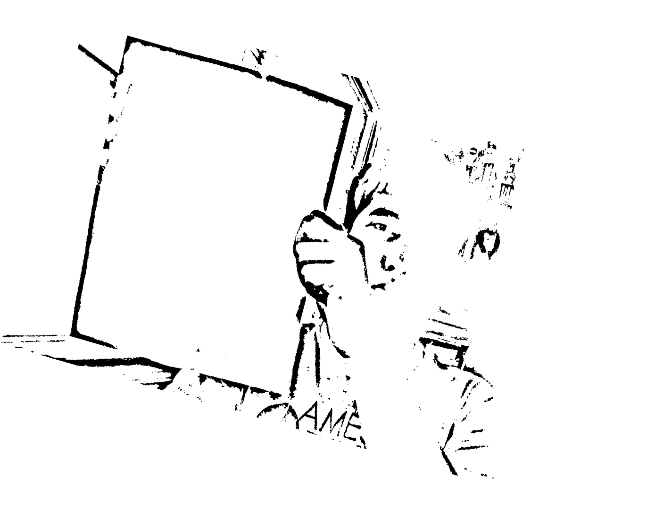

In [4]:
display(cv.resize(ndimage.rotate(get_canvases('canvases')[0].img, angle=-15.43, cval=255), (672, 512)))

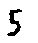

In [5]:
names, imgs = get_img_data('nums/ones')
num_sampler = Sampler(imgs)
num = num_sampler.get_sample()

display(num)

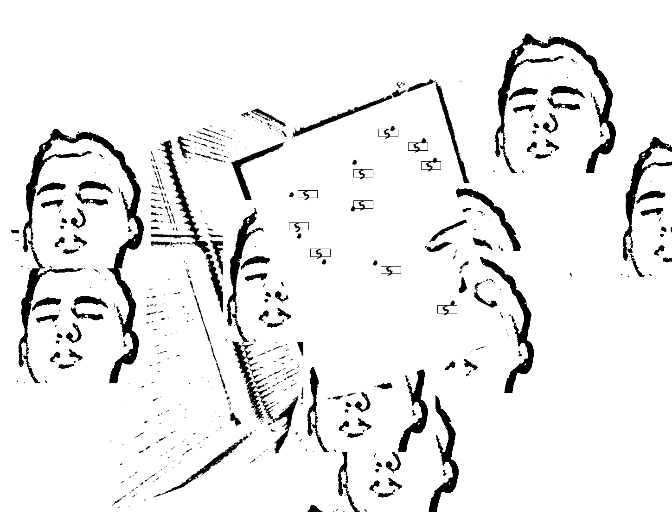

In [272]:
blanks = get_canvases('canvases')
blank_sampler = Sampler(blanks)

a = blank_sampler.get_sample()
a.img = adaptive_thresh(a.img)

names, imgs = get_img_data('nums/ones')
num_sampler = Sampler(imgs)

func = [place_above, place_below, place_left, place_right]

bbox = {}

dot = np.load('dots/1.npy')
dot = adaptive_thresh(dot)

for i in range(10):
    num = num_sampler.get_sample()
    scalar = random.uniform(.8,.8)
    
    num = cv.resize(num, (int(num.shape[0]*scalar), int(num.shape[1]*scalar)))
    num = adaptive_thresh(num)
    row = random.randint(a.min_row, a.max_row)
    col = random.randint(a.min_col, a.max_col)
    
    while not a.draw_on_paper(num, (row, col)):
        row = random.randint(a.min_row, a.max_row)
        col = random.randint(a.min_col, a.max_col)
    
    # placed num
    
    if '1' not in bbox:
        bbox['1'] = []
        
        # tl tr br bl
    
    bbox['1'].append( ((col, row), (col+num.shape[1], row), (col+num.shape[1], row+num.shape[0]), (col, row+num.shape[0])) )

    top_left = row, col
    bot_right = row+dot.shape[0], col+dot.shape[1]
    
    dot_coords = {}
    dot_coords['min_row'] = top_left[0]
    dot_coords['max_row'] = bot_right[0]
    dot_coords['min_col'] = top_left[1]
    dot_coords['max_col'] = bot_right[1]

    np.random.shuffle(func)
    
    scalar = .6    
    dz = dot.copy()
    dz = cv.resize(dz, ( int(dz.shape[0]*scalar), int(dz.shape[1]*scalar)))
    dz = adaptive_thresh(dz)

    for f in func:
        if f(a, dz, dot_coords):
            break
            
            
def totally_inside_paper(top_left_obj, obj, canvas):
    bot_right_obj = (top_left_obj[0]+obj.shape[0], top_left_obj[1]+obj.shape[1])
    bot_left_obj = bot_right_obj[0], top_left_obj[1]
    top_right_obj = top_left_obj[0], bot_right_obj[1]    

    obj_corners = [top_left_obj, top_right_obj, bot_right_obj, bot_left_obj]

    all_inside = True
    for corner in obj_corners:
        all_inside = all_inside and (cv.pointPolygonTest(canvas.x_y_contours, (corner[1], corner[0]), False) > 0.0)
    
    return all_inside

deg = 20

a.rotate(deg)
rad = np.deg2rad(deg)
rt = np.array([[np.cos(rad), np.sin(rad)], [-np.sin(rad), np.cos(rad)]])

for k,v in bbox.items():
    for obj in v:
        nw = np.dot(rt, np.array(obj).T - np.array([1280/2, 720/2]).reshape(2,-1)) + np.array([a.img.shape[1]/2, a.img.shape[0]/2]).reshape(2,-1)
        nw = nw.astype(np.int32)

        a.img = cv.rectangle(a.img, tuple(nw[:, 0]), tuple(nw[:, 2]), (0), 1)

k = np.load('backgrounds/1.npy')

cnt = 10
for i in range(cnt):

    rr = random.randint(0, a.img.shape[0])
    rc = random.randint(0, a.img.shape[1])

    while(totally_inside_paper((rr,rc), k, a)):
        rr = random.randint(0, a.img.shape[0])
        rc = random.randint(0, a.img.shape[1])

    a.draw_on_background(k, (rr,rc))
    
display(cv.resize(a.img, (672, 512)))

In [197]:
(100,3)[::-1]

(3, 100)

In [190]:
con = a.contours
x_y_contours = np.array([i[::-1] for i in con])
np.dot(rt, x_y_contours.T - [5,5])
x_y_contours.T

array([[ 95, 630, 630,  95],
       [ 48,  48, 662, 662]])

In [193]:
a.img.shape

(720, 1280)

In [194]:
x_y_contours.T - (100,100)

ValueError: operands could not be broadcast together with shapes (2,4) (2,) 

In [78]:
l

[32]

In [134]:
contours = np.array([(0, 0), (0, 100), (100,100), (100, 0)])
if cv.pointPolygonTest(contours, (50,50), False):
    print('yeah')

yeah


In [56]:
m = 0.8

if m:
    print(32)

32
